In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [4]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [6]:
pd.set_option('display.max_columns',500)

In [7]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [8]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,12.5380,0.9205,10.5998,7.5147,-4.1748,-0.4824,10.5267,17.7547,-6.5226,-2.5502,-5.1547,-2.1246,19.8319,13.0752,9.2275,3.0213,11.6793,-11.6827,4.1017,5.2954,18.7741,9.8892,7.5219,14.9745,18.9880,1.0842,11.9125,-4.5103,16.1361,11.0067,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,-1.5536,10.0309,3.1337,10.5742,11.7664,2.1782,-41.1924,13.5322,-17.3834,6.3806,12.5589,11.6887,25.3930,1.5776,6.8481,8.7348,16.4239,21.7056,6.9345,1.6678,9.5249,5.3383,-18.7083,1.3382,-1.7401,5.8398,3.1051,4.4307,16.0005,5.0306,-7.3365,12.2806,0.6992,-0.7772,21.5123,6.7803,18.1896,6.9388,22.1336,6.3755,13.1525,1.9772,14.0406,6.6904,9.9732,-11.5679,20.4525,9.4951,9.6343,8.1252,2.6059,-17.4201,7.1848,15.3484,10.6522,5.9897,0.3392,10.3516,29.8204,1.9998,-1.4166,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,17.0488,11.6704,3.1215,8.5093,5.6367,12.0099,14.2372,-

In [9]:
print(train_df.shape,test_df.shape)

(200000, 202) (200000, 201)


Xgboost

In [10]:
import xgboost as xgb
from matplotlib import pyplot

In [11]:
XGBOOST_PARAM = {
    'random_state' : 42,
    'n_estimators' : 25, 
    'learning_rate': 0.15,   ### importtant
    'num_leaves': 36,        ### important
    'max_depth': 6,         ### important
    'metric' : ['auc'],
    'reg_alpha' : 2.03,     ### important
    'reg_lambda' : 4.7,     ### important  
    'feature_fraction' : 0.8, #colsample_bytree, important
    'feature_fraction_seed' : 42,   
    'max_bins' : 100,         
    'min_split_gain': 0.0148,   
    'min_child_weight' : 7.835, #min_sum_hessian_in_leaf 
    'min_data_in_leaf' : 1000, #min_child_samples
    'random_state' : 1981, # Updated from 'seed'
    'subsample' : .912, #also known as Bagging fraction!
    'subsample_freq' : 200, # also known as bagging frequency!
    'boost_from_average' : False,
    'verbose_eval' : 10,
    'is_unbalance' : True ### to address class imbalance
    }

In [12]:
XGBGBDT = xgb.XGBClassifier(**XGBOOST_PARAM,
                            silent=0,
                            )

In [13]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']
folds = StratifiedKFold(n_splits=3, shuffle=False, random_state=2319)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_X = train_df.iloc[trn_idx][features]
    trn_Y = target.iloc[trn_idx]
    val_X = train_df.iloc[val_idx][features]
    val_Y = target.iloc[val_idx]
    
    
    clf = XGBGBDT.fit(trn_X, trn_Y,
                      eval_set=[(trn_X, trn_Y),(val_X, val_Y)],
                        eval_metric='auc',early_stopping_rounds=100,
                        verbose=25)
            
    oof[val_idx] = clf.predict_proba(train_df.iloc[val_idx][features])[:,1]
    predictions += clf.predict_proba(test_df[features])[:,1] / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = predictions
sub.to_csv("submission_XGB.csv", index=False)

Fold 0
[0]	validation_0-auc:0.645841	validation_1-auc:0.630538
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[24]	validation_0-auc:0.85716	validation_1-auc:0.788011
Fold 1
[0]	validation_0-auc:0.65037	validation_1-auc:0.63946
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[24]	validation_0-auc:0.858227	validation_1-auc:0.790227
Fold 2
[0]	validation_0-auc:0.642843	validation_1-auc:0.6383
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[24]	validation_0-auc:0.857197	validation_1-auc:0.799151
CV score: 0.79238 


[0.01285918 0.01006799 0.01144071 0.00320461 0.0041488  0.00512554
 0.01237228 0.003003   0.00239517 0.00815687 0.00250368 0.00269728
 0.02056325 0.01295865 0.00234531 0.00338571 0.00432624 0.
 0.01048604 0.00287871 0.00215152 0.01158881 0.01289392 0.00196741
 0.0042316  0.00127796 0.01479901 0.         0.00315512 0.
 0.00265939 0.00224105 0.         0.0111109  0.01079331 0.00624877
 0.00191651 0.00365099 0.0022501  0.00114354 0.01220895 0.00306341
 0.00038053 0.00220241 0.01684345 0.00255902 0.0015986  0.00352369
 0.00343284 0.00238719 0.         0.00393736 0.         0.01538552
 0.00280412 0.00361286 0.00332984 0.         0.0026408  0.00128165
 0.         0.00211256 0.00296732 0.         0.         0.00356239
 0.00313928 0.00578213 0.00115878 0.         0.00230375 0.00398195
 0.00172478 0.00249579 0.00254095 0.00292808 0.01167265 0.00234098
 0.01440311 0.00095631 0.01080278 0.03554032 0.00242103 0.00153591
 0.00299941 0.         0.00812162 0.00362468 0.00272959 0.00517463
 0.00278749

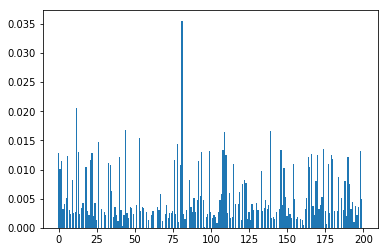

In [14]:
# feature importance
print(clf.feature_importances_)
# plot
pyplot.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
pyplot.show()

LightGBM

In [15]:
feature_importance_df = pd.DataFrame()
param = {
    'bagging_freq': 5,  'bagging_fraction': 0.331,  'boost_from_average':'false',   
    'boost': 'gbdt',    'feature_fraction': 0.0405, 'learning_rate': 0.0083,
    'max_depth': -1,    'metric':'auc',             'min_data_in_leaf': 80,     
    'min_sum_hessian_in_leaf': 10.0,'num_leaves': 13,  'num_threads': 8,            
    'tree_learner': 'serial',   'objective': 'binary',       'verbosity': 1
}
folds = StratifiedKFold(n_splits=3, shuffle=False, random_state=42)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 5000, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    ### variable importance plot utility
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = predictions
sub.to_csv("submission_LGBM.csv", index=False)

Fold 0
Training until validation scores don't improve for 250 rounds.
[500]	training's auc: 0.897575	valid_1's auc: 0.8763
[1000]	training's auc: 0.905835	valid_1's auc: 0.883109
[1500]	training's auc: 0.911666	valid_1's auc: 0.887141
[2000]	training's auc: 0.916265	valid_1's auc: 0.890224
[2500]	training's auc: 0.920021	valid_1's auc: 0.892306
[3000]	training's auc: 0.923022	valid_1's auc: 0.893591
[3500]	training's auc: 0.925911	valid_1's auc: 0.894866
[4000]	training's auc: 0.928448	valid_1's auc: 0.895655
[4500]	training's auc: 0.930696	valid_1's auc: 0.896219
[5000]	training's auc: 0.932925	valid_1's auc: 0.896786
Did not meet early stopping. Best iteration is:
[5000]	training's auc: 0.932925	valid_1's auc: 0.896786
Fold 1
Training until validation scores don't improve for 250 rounds.
[500]	training's auc: 0.895872	valid_1's auc: 0.876466
[1000]	training's auc: 0.904789	valid_1's auc: 0.883964
[1500]	training's auc: 0.910823	valid_1's auc: 0.888098
[2000]	training's auc: 0.915684	

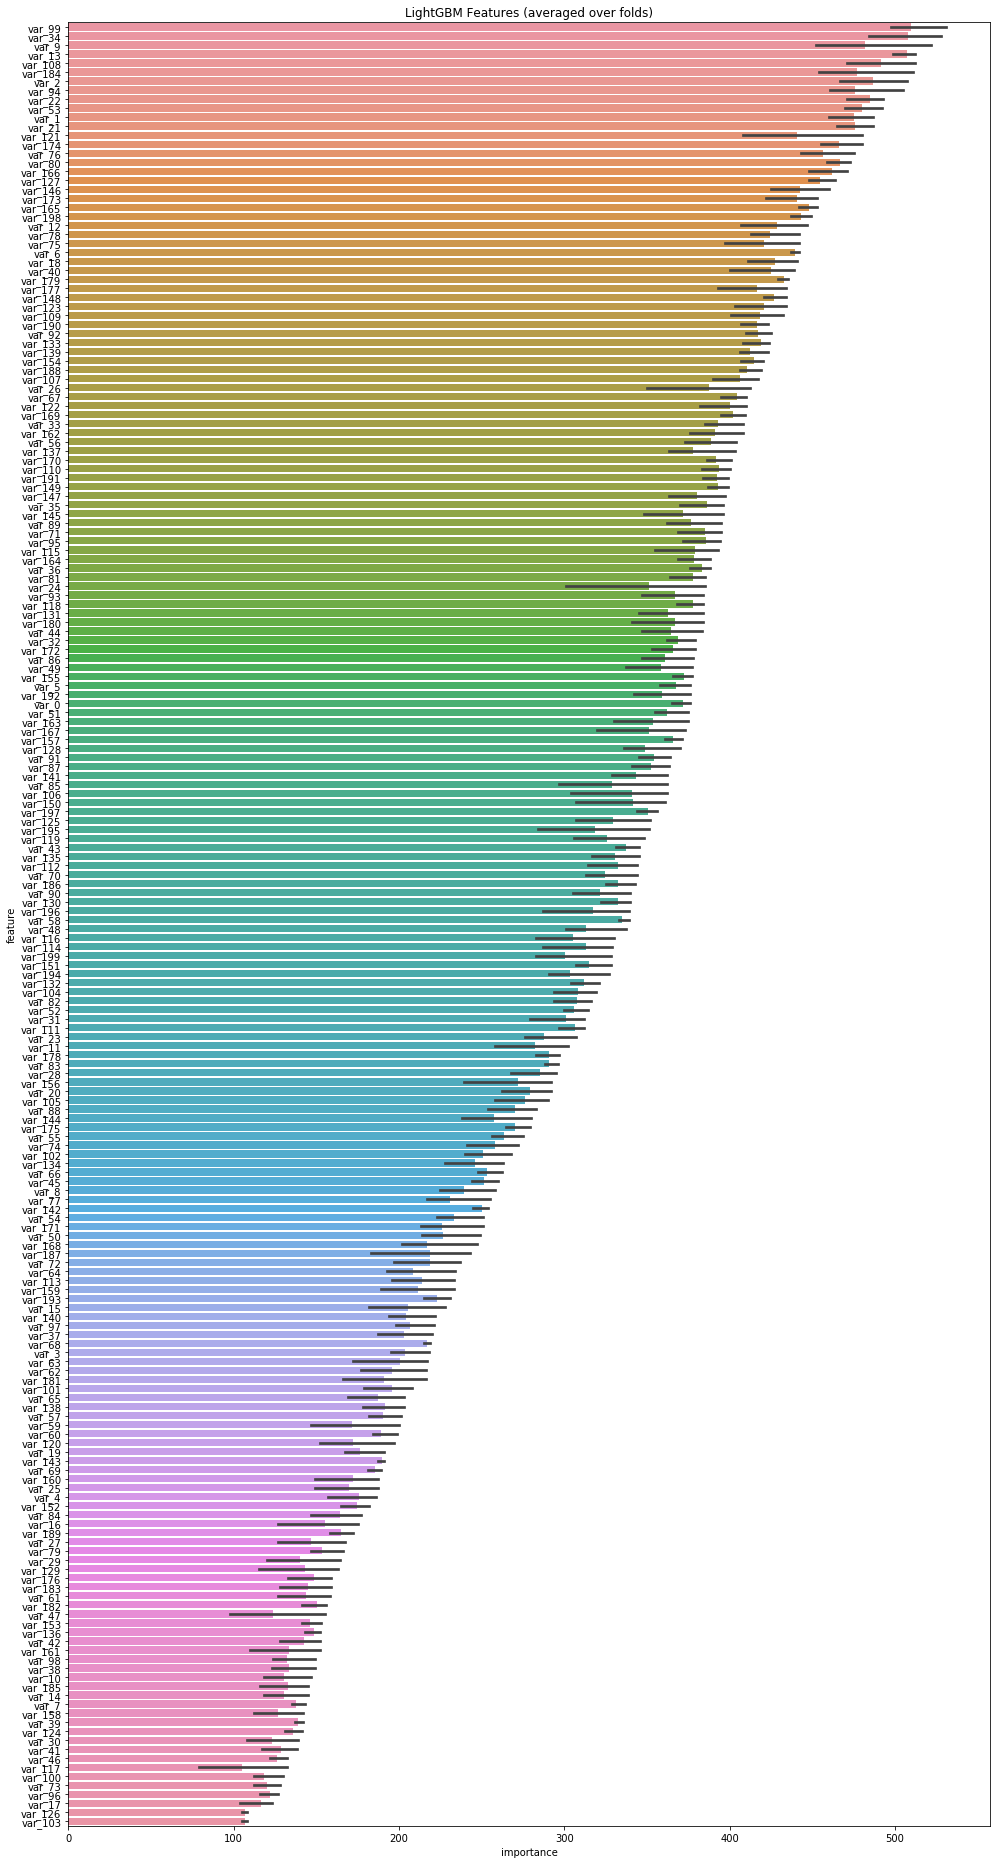

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [23]:

from catboost import CatBoostClassifier



In [24]:
MAX_ROUNDS = 650
OPTIMIZE_ROUNDS = False
LEARNING_RATE = 0.05


In [ ]:
model = CatBoostClassifier(
    learning_rate=LEARNING_RATE, 
    depth=6, 
    l2_leaf_reg = 14, 
    iterations = MAX_ROUNDS,
#    verbose = True,
    loss_function='Logloss'
)

In [ ]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']
folds = StratifiedKFold(n_splits=3, shuffle=False, random_state=2319)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_X = train_df.iloc[trn_idx][features]
    trn_Y = target.iloc[trn_idx]
    val_X = train_df.iloc[val_idx][features]
    val_Y = target.iloc[val_idx]
    
    
    clf = model.fit(trn_X, trn_Y,
                      eval_set=[(trn_X, trn_Y),(val_X, val_Y)],
                        use_best_model=True)
            
    oof[val_idx] = clf.predict_proba(train_df.iloc[val_idx][features])[:,1]
    predictions += clf.predict_proba(test_df[features])[:,1] / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = predictions
sub.to_csv("submission_catboost.csv", index=False)

Fold 0
0:	learn: 0.6503316	test: 0.6503316	test1: 0.6503306	best: 0.6503306 (0)	total: 247ms	remaining: 2m 40s
1:	learn: 0.6126784	test: 0.6126784	test1: 0.6127199	best: 0.6127199 (1)	total: 433ms	remaining: 2m 20s
2:	learn: 0.5789192	test: 0.5789192	test1: 0.5790013	best: 0.5790013 (2)	total: 610ms	remaining: 2m 11s
3:	learn: 0.5487454	test: 0.5487454	test1: 0.5488078	best: 0.5488078 (3)	total: 776ms	remaining: 2m 5s
4:	learn: 0.5227858	test: 0.5227858	test1: 0.5228889	best: 0.5228889 (4)	total: 951ms	remaining: 2m 2s
5:	learn: 0.4987322	test: 0.4987322	test1: 0.4989013	best: 0.4989013 (5)	total: 1.13s	remaining: 2m 1s
6:	learn: 0.4776473	test: 0.4776473	test1: 0.4778959	best: 0.4778959 (6)	total: 1.3s	remaining: 1m 59s
7:	learn: 0.4592313	test: 0.4592313	test1: 0.4594869	best: 0.4594869 (7)	total: 1.47s	remaining: 1m 57s
8:	learn: 0.4426208	test: 0.4426208	test1: 0.4429069	best: 0.4429069 (8)	total: 1.64s	remaining: 1m 56s
9:	learn: 0.4287068	test: 0.4287068	test1: 0.4290434	best: 0.

78:	learn: 0.2807555	test: 0.2807555	test1: 0.2838748	best: 0.2838748 (78)	total: 12.6s	remaining: 1m 31s
79:	learn: 0.2803414	test: 0.2803414	test1: 0.2834890	best: 0.2834890 (79)	total: 12.8s	remaining: 1m 31s
80:	learn: 0.2799457	test: 0.2799457	test1: 0.2831339	best: 0.2831339 (80)	total: 12.9s	remaining: 1m 30s
81:	learn: 0.2795483	test: 0.2795483	test1: 0.2827480	best: 0.2827480 (81)	total: 13.1s	remaining: 1m 30s
82:	learn: 0.2791695	test: 0.2791695	test1: 0.2823706	best: 0.2823706 (82)	total: 13.2s	remaining: 1m 30s
83:	learn: 0.2788065	test: 0.2788065	test1: 0.2820502	best: 0.2820502 (83)	total: 13.4s	remaining: 1m 30s
84:	learn: 0.2784226	test: 0.2784226	test1: 0.2816838	best: 0.2816838 (84)	total: 13.5s	remaining: 1m 30s
85:	learn: 0.2780993	test: 0.2780993	test1: 0.2813781	best: 0.2813781 (85)	total: 13.7s	remaining: 1m 29s
86:	learn: 0.2776900	test: 0.2776900	test1: 0.2809953	best: 0.2809953 (86)	total: 13.9s	remaining: 1m 29s
87:	learn: 0.2773455	test: 0.2773455	test1: 0.

156:	learn: 0.2573440	test: 0.2573440	test1: 0.2626752	best: 0.2626752 (156)	total: 24.7s	remaining: 1m 17s
157:	learn: 0.2571136	test: 0.2571136	test1: 0.2624557	best: 0.2624557 (157)	total: 24.9s	remaining: 1m 17s
158:	learn: 0.2568820	test: 0.2568820	test1: 0.2622278	best: 0.2622278 (158)	total: 25.1s	remaining: 1m 17s
159:	learn: 0.2566880	test: 0.2566880	test1: 0.2620466	best: 0.2620466 (159)	total: 25.2s	remaining: 1m 17s
160:	learn: 0.2564620	test: 0.2564620	test1: 0.2618616	best: 0.2618616 (160)	total: 25.4s	remaining: 1m 17s
161:	learn: 0.2562591	test: 0.2562591	test1: 0.2616841	best: 0.2616841 (161)	total: 25.5s	remaining: 1m 16s
162:	learn: 0.2560381	test: 0.2560381	test1: 0.2615113	best: 0.2615113 (162)	total: 25.7s	remaining: 1m 16s
163:	learn: 0.2557912	test: 0.2557912	test1: 0.2613047	best: 0.2613047 (163)	total: 25.8s	remaining: 1m 16s
164:	learn: 0.2555581	test: 0.2555581	test1: 0.2611050	best: 0.2611050 (164)	total: 26s	remaining: 1m 16s
165:	learn: 0.2553218	test: 0.

234:	learn: 0.2423528	test: 0.2423528	test1: 0.2497927	best: 0.2497927 (234)	total: 37s	remaining: 1m 5s
235:	learn: 0.2421924	test: 0.2421924	test1: 0.2496606	best: 0.2496606 (235)	total: 37.2s	remaining: 1m 5s
236:	learn: 0.2420504	test: 0.2420504	test1: 0.2495287	best: 0.2495287 (236)	total: 37.3s	remaining: 1m 5s
237:	learn: 0.2419023	test: 0.2419023	test1: 0.2493963	best: 0.2493963 (237)	total: 37.5s	remaining: 1m 4s
238:	learn: 0.2417261	test: 0.2417261	test1: 0.2492315	best: 0.2492315 (238)	total: 37.6s	remaining: 1m 4s
239:	learn: 0.2415579	test: 0.2415579	test1: 0.2491076	best: 0.2491076 (239)	total: 37.8s	remaining: 1m 4s
240:	learn: 0.2413919	test: 0.2413919	test1: 0.2489727	best: 0.2489727 (240)	total: 38s	remaining: 1m 4s
241:	learn: 0.2412203	test: 0.2412203	test1: 0.2488275	best: 0.2488275 (241)	total: 38.1s	remaining: 1m 4s
242:	learn: 0.2410506	test: 0.2410506	test1: 0.2486724	best: 0.2486724 (242)	total: 38.3s	remaining: 1m 4s
243:	learn: 0.2409023	test: 0.2409023	tes

312:	learn: 0.2311807	test: 0.2311807	test1: 0.2406398	best: 0.2406398 (312)	total: 49.4s	remaining: 53.2s
313:	learn: 0.2310598	test: 0.2310598	test1: 0.2405422	best: 0.2405422 (313)	total: 49.6s	remaining: 53.1s
314:	learn: 0.2309378	test: 0.2309378	test1: 0.2404646	best: 0.2404646 (314)	total: 49.8s	remaining: 52.9s
315:	learn: 0.2308196	test: 0.2308196	test1: 0.2403603	best: 0.2403603 (315)	total: 49.9s	remaining: 52.8s
316:	learn: 0.2307048	test: 0.2307048	test1: 0.2402780	best: 0.2402780 (316)	total: 50.1s	remaining: 52.6s
317:	learn: 0.2305928	test: 0.2305928	test1: 0.2401878	best: 0.2401878 (317)	total: 50.2s	remaining: 52.4s
318:	learn: 0.2304757	test: 0.2304757	test1: 0.2401111	best: 0.2401111 (318)	total: 50.4s	remaining: 52.3s
319:	learn: 0.2303721	test: 0.2303721	test1: 0.2400374	best: 0.2400374 (319)	total: 50.5s	remaining: 52.1s
320:	learn: 0.2302480	test: 0.2302480	test1: 0.2399330	best: 0.2399330 (320)	total: 50.7s	remaining: 51.9s
321:	learn: 0.2301254	test: 0.2301254

390:	learn: 0.2224811	test: 0.2224811	test1: 0.2341725	best: 0.2341725 (390)	total: 1m 1s	remaining: 41s
391:	learn: 0.2223846	test: 0.2223846	test1: 0.2340821	best: 0.2340821 (391)	total: 1m 2s	remaining: 40.8s
392:	learn: 0.2222792	test: 0.2222792	test1: 0.2340145	best: 0.2340145 (392)	total: 1m 2s	remaining: 40.7s
393:	learn: 0.2221747	test: 0.2221747	test1: 0.2339373	best: 0.2339373 (393)	total: 1m 2s	remaining: 40.5s
394:	learn: 0.2220776	test: 0.2220776	test1: 0.2338574	best: 0.2338574 (394)	total: 1m 2s	remaining: 40.4s
395:	learn: 0.2219808	test: 0.2219808	test1: 0.2337928	best: 0.2337928 (395)	total: 1m 2s	remaining: 40.2s
396:	learn: 0.2218684	test: 0.2218684	test1: 0.2337161	best: 0.2337161 (396)	total: 1m 2s	remaining: 40.1s
397:	learn: 0.2217654	test: 0.2217654	test1: 0.2336433	best: 0.2336433 (397)	total: 1m 3s	remaining: 39.9s
398:	learn: 0.2216577	test: 0.2216577	test1: 0.2335795	best: 0.2335795 (398)	total: 1m 3s	remaining: 39.8s
399:	learn: 0.2215645	test: 0.2215645	t

468:	learn: 0.2155278	test: 0.2155278	test1: 0.2292470	best: 0.2292470 (468)	total: 1m 14s	remaining: 28.8s
469:	learn: 0.2154474	test: 0.2154474	test1: 0.2291853	best: 0.2291853 (469)	total: 1m 14s	remaining: 28.6s
470:	learn: 0.2153588	test: 0.2153588	test1: 0.2291361	best: 0.2291361 (470)	total: 1m 14s	remaining: 28.5s
471:	learn: 0.2152754	test: 0.2152754	test1: 0.2290754	best: 0.2290754 (471)	total: 1m 15s	remaining: 28.3s
472:	learn: 0.2151906	test: 0.2151906	test1: 0.2290049	best: 0.2290049 (472)	total: 1m 15s	remaining: 28.2s
473:	learn: 0.2151083	test: 0.2151083	test1: 0.2289564	best: 0.2289564 (473)	total: 1m 15s	remaining: 28s
474:	learn: 0.2150282	test: 0.2150282	test1: 0.2289063	best: 0.2289063 (474)	total: 1m 15s	remaining: 27.8s
475:	learn: 0.2149485	test: 0.2149485	test1: 0.2288538	best: 0.2288538 (475)	total: 1m 15s	remaining: 27.7s
476:	learn: 0.2148616	test: 0.2148616	test1: 0.2288100	best: 0.2288100 (476)	total: 1m 15s	remaining: 27.5s
477:	learn: 0.2147961	test: 0.

544:	learn: 0.2099312	test: 0.2099312	test1: 0.2256227	best: 0.2256227 (544)	total: 1m 26s	remaining: 16.7s
545:	learn: 0.2098448	test: 0.2098448	test1: 0.2255831	best: 0.2255831 (545)	total: 1m 26s	remaining: 16.6s
546:	learn: 0.2097833	test: 0.2097833	test1: 0.2255381	best: 0.2255381 (546)	total: 1m 27s	remaining: 16.4s
547:	learn: 0.2097206	test: 0.2097206	test1: 0.2254989	best: 0.2254989 (547)	total: 1m 27s	remaining: 16.3s
548:	learn: 0.2096577	test: 0.2096577	test1: 0.2254571	best: 0.2254571 (548)	total: 1m 27s	remaining: 16.1s
549:	learn: 0.2095930	test: 0.2095930	test1: 0.2254096	best: 0.2254096 (549)	total: 1m 27s	remaining: 15.9s
550:	learn: 0.2095399	test: 0.2095399	test1: 0.2253682	best: 0.2253682 (550)	total: 1m 27s	remaining: 15.8s
551:	learn: 0.2094636	test: 0.2094636	test1: 0.2253242	best: 0.2253242 (551)	total: 1m 27s	remaining: 15.6s
552:	learn: 0.2093927	test: 0.2093927	test1: 0.2252967	best: 0.2252967 (552)	total: 1m 28s	remaining: 15.5s
553:	learn: 0.2093272	test: 

620:	learn: 0.2049792	test: 0.2049792	test1: 0.2225156	best: 0.2225156 (620)	total: 1m 39s	remaining: 4.63s
621:	learn: 0.2049091	test: 0.2049091	test1: 0.2224764	best: 0.2224764 (621)	total: 1m 39s	remaining: 4.47s
622:	learn: 0.2048421	test: 0.2048421	test1: 0.2224433	best: 0.2224433 (622)	total: 1m 39s	remaining: 4.31s
623:	learn: 0.2047863	test: 0.2047863	test1: 0.2224048	best: 0.2224048 (623)	total: 1m 39s	remaining: 4.15s
624:	learn: 0.2047169	test: 0.2047169	test1: 0.2223645	best: 0.2223645 (624)	total: 1m 39s	remaining: 3.99s
625:	learn: 0.2046583	test: 0.2046583	test1: 0.2223349	best: 0.2223349 (625)	total: 1m 40s	remaining: 3.83s
626:	learn: 0.2046066	test: 0.2046066	test1: 0.2223039	best: 0.2223039 (626)	total: 1m 40s	remaining: 3.67s
627:	learn: 0.2045409	test: 0.2045409	test1: 0.2222766	best: 0.2222766 (627)	total: 1m 40s	remaining: 3.51s
628:	learn: 0.2044789	test: 0.2044789	test1: 0.2222327	best: 0.2222327 (628)	total: 1m 40s	remaining: 3.35s
629:	learn: 0.2044305	test: 

48:	learn: 0.2954482	test: 0.2954482	test1: 0.2974546	best: 0.2974546 (48)	total: 7.88s	remaining: 1m 36s
49:	learn: 0.2947819	test: 0.2947819	test1: 0.2968170	best: 0.2968170 (49)	total: 8.03s	remaining: 1m 36s
50:	learn: 0.2941770	test: 0.2941770	test1: 0.2962297	best: 0.2962297 (50)	total: 8.17s	remaining: 1m 35s
51:	learn: 0.2934946	test: 0.2934946	test1: 0.2955777	best: 0.2955777 (51)	total: 8.34s	remaining: 1m 35s
52:	learn: 0.2929084	test: 0.2929084	test1: 0.2950124	best: 0.2950124 (52)	total: 8.48s	remaining: 1m 35s
53:	learn: 0.2922826	test: 0.2922826	test1: 0.2944226	best: 0.2944226 (53)	total: 8.63s	remaining: 1m 35s
54:	learn: 0.2917517	test: 0.2917517	test1: 0.2938910	best: 0.2938910 (54)	total: 8.77s	remaining: 1m 34s
55:	learn: 0.2911829	test: 0.2911829	test1: 0.2933339	best: 0.2933339 (55)	total: 8.92s	remaining: 1m 34s
56:	learn: 0.2906527	test: 0.2906527	test1: 0.2928485	best: 0.2928485 (56)	total: 9.07s	remaining: 1m 34s
57:	learn: 0.2901105	test: 0.2901105	test1: 0.

126:	learn: 0.2648578	test: 0.2648578	test1: 0.2692296	best: 0.2692296 (126)	total: 19.9s	remaining: 1m 21s
127:	learn: 0.2645746	test: 0.2645746	test1: 0.2689826	best: 0.2689826 (127)	total: 20s	remaining: 1m 21s
128:	learn: 0.2642818	test: 0.2642818	test1: 0.2687006	best: 0.2687006 (128)	total: 20.2s	remaining: 1m 21s
129:	learn: 0.2640004	test: 0.2640004	test1: 0.2684744	best: 0.2684744 (129)	total: 20.4s	remaining: 1m 21s
130:	learn: 0.2637530	test: 0.2637530	test1: 0.2682607	best: 0.2682607 (130)	total: 20.5s	remaining: 1m 21s
131:	learn: 0.2634806	test: 0.2634806	test1: 0.2680354	best: 0.2680354 (131)	total: 20.7s	remaining: 1m 21s
132:	learn: 0.2632011	test: 0.2632011	test1: 0.2678020	best: 0.2678020 (132)	total: 20.8s	remaining: 1m 21s
133:	learn: 0.2629018	test: 0.2629018	test1: 0.2675205	best: 0.2675205 (133)	total: 21s	remaining: 1m 20s
134:	learn: 0.2626522	test: 0.2626522	test1: 0.2672917	best: 0.2672917 (134)	total: 21.2s	remaining: 1m 20s
135:	learn: 0.2624095	test: 0.26

204:	learn: 0.2476725	test: 0.2476725	test1: 0.2537266	best: 0.2537266 (204)	total: 32.1s	remaining: 1m 9s
205:	learn: 0.2475011	test: 0.2475011	test1: 0.2535686	best: 0.2535686 (205)	total: 32.3s	remaining: 1m 9s
206:	learn: 0.2473328	test: 0.2473328	test1: 0.2534194	best: 0.2534194 (206)	total: 32.5s	remaining: 1m 9s
207:	learn: 0.2471565	test: 0.2471565	test1: 0.2532620	best: 0.2532620 (207)	total: 32.6s	remaining: 1m 9s
208:	learn: 0.2469808	test: 0.2469808	test1: 0.2531156	best: 0.2531156 (208)	total: 32.8s	remaining: 1m 9s
209:	learn: 0.2467853	test: 0.2467853	test1: 0.2529449	best: 0.2529449 (209)	total: 32.9s	remaining: 1m 9s
210:	learn: 0.2466000	test: 0.2466000	test1: 0.2527854	best: 0.2527854 (210)	total: 33.1s	remaining: 1m 8s
211:	learn: 0.2464354	test: 0.2464354	test1: 0.2526148	best: 0.2526148 (211)	total: 33.3s	remaining: 1m 8s
212:	learn: 0.2462691	test: 0.2462691	test1: 0.2524674	best: 0.2524674 (212)	total: 33.4s	remaining: 1m 8s
213:	learn: 0.2460969	test: 0.2460969

282:	learn: 0.2354787	test: 0.2354787	test1: 0.2433861	best: 0.2433861 (282)	total: 44.5s	remaining: 57.7s
283:	learn: 0.2353586	test: 0.2353586	test1: 0.2432764	best: 0.2432764 (283)	total: 44.6s	remaining: 57.5s
284:	learn: 0.2352181	test: 0.2352181	test1: 0.2431730	best: 0.2431730 (284)	total: 44.8s	remaining: 57.3s
285:	learn: 0.2350801	test: 0.2350801	test1: 0.2430441	best: 0.2430441 (285)	total: 44.9s	remaining: 57.2s
286:	learn: 0.2349196	test: 0.2349196	test1: 0.2429141	best: 0.2429141 (286)	total: 45.1s	remaining: 57s
287:	learn: 0.2347915	test: 0.2347915	test1: 0.2428269	best: 0.2428269 (287)	total: 45.2s	remaining: 56.9s
288:	learn: 0.2346610	test: 0.2346610	test1: 0.2427174	best: 0.2427174 (288)	total: 45.4s	remaining: 56.7s
289:	learn: 0.2345010	test: 0.2345010	test1: 0.2425992	best: 0.2425992 (289)	total: 45.6s	remaining: 56.6s
290:	learn: 0.2343849	test: 0.2343849	test1: 0.2425055	best: 0.2425055 (290)	total: 45.7s	remaining: 56.4s
291:	learn: 0.2342597	test: 0.2342597	t

360:	learn: 0.2261394	test: 0.2261394	test1: 0.2357883	best: 0.2357883 (360)	total: 57s	remaining: 45.7s
361:	learn: 0.2260370	test: 0.2260370	test1: 0.2356939	best: 0.2356939 (361)	total: 57.2s	remaining: 45.5s
362:	learn: 0.2259383	test: 0.2259383	test1: 0.2356274	best: 0.2356274 (362)	total: 57.4s	remaining: 45.3s
363:	learn: 0.2258440	test: 0.2258440	test1: 0.2355618	best: 0.2355618 (363)	total: 57.5s	remaining: 45.2s
364:	learn: 0.2257407	test: 0.2257407	test1: 0.2354738	best: 0.2354738 (364)	total: 57.7s	remaining: 45s
365:	learn: 0.2256235	test: 0.2256235	test1: 0.2353918	best: 0.2353918 (365)	total: 57.8s	remaining: 44.9s
366:	learn: 0.2255263	test: 0.2255263	test1: 0.2353181	best: 0.2353181 (366)	total: 58s	remaining: 44.7s
367:	learn: 0.2254245	test: 0.2254245	test1: 0.2352450	best: 0.2352450 (367)	total: 58.2s	remaining: 44.6s
368:	learn: 0.2253170	test: 0.2253170	test1: 0.2351618	best: 0.2351618 (368)	total: 58.4s	remaining: 44.4s
369:	learn: 0.2252231	test: 0.2252231	test1

438:	learn: 0.2187164	test: 0.2187164	test1: 0.2302482	best: 0.2302482 (438)	total: 1m 9s	remaining: 33.6s
439:	learn: 0.2186397	test: 0.2186397	test1: 0.2301967	best: 0.2301967 (439)	total: 1m 10s	remaining: 33.4s
440:	learn: 0.2185563	test: 0.2185563	test1: 0.2301314	best: 0.2301314 (440)	total: 1m 10s	remaining: 33.3s
441:	learn: 0.2184862	test: 0.2184862	test1: 0.2300830	best: 0.2300830 (441)	total: 1m 10s	remaining: 33.1s
442:	learn: 0.2183883	test: 0.2183883	test1: 0.2300206	best: 0.2300206 (442)	total: 1m 10s	remaining: 33s
443:	learn: 0.2183129	test: 0.2183129	test1: 0.2299722	best: 0.2299722 (443)	total: 1m 10s	remaining: 32.8s
444:	learn: 0.2182211	test: 0.2182211	test1: 0.2299182	best: 0.2299182 (444)	total: 1m 10s	remaining: 32.6s
445:	learn: 0.2181350	test: 0.2181350	test1: 0.2298667	best: 0.2298667 (445)	total: 1m 11s	remaining: 32.5s
446:	learn: 0.2180481	test: 0.2180481	test1: 0.2298023	best: 0.2298023 (446)	total: 1m 11s	remaining: 32.3s
447:	learn: 0.2179605	test: 0.2

516:	learn: 0.2125193	test: 0.2125193	test1: 0.2259653	best: 0.2259653 (516)	total: 1m 22s	remaining: 21.2s
517:	learn: 0.2124482	test: 0.2124482	test1: 0.2259221	best: 0.2259221 (517)	total: 1m 22s	remaining: 21.1s
518:	learn: 0.2123604	test: 0.2123604	test1: 0.2258784	best: 0.2258784 (518)	total: 1m 22s	remaining: 20.9s
519:	learn: 0.2122839	test: 0.2122839	test1: 0.2258250	best: 0.2258250 (519)	total: 1m 23s	remaining: 20.8s
520:	learn: 0.2122102	test: 0.2122102	test1: 0.2257705	best: 0.2257705 (520)	total: 1m 23s	remaining: 20.6s
521:	learn: 0.2121336	test: 0.2121336	test1: 0.2257227	best: 0.2257227 (521)	total: 1m 23s	remaining: 20.4s
522:	learn: 0.2120490	test: 0.2120490	test1: 0.2256526	best: 0.2256526 (522)	total: 1m 23s	remaining: 20.3s
523:	learn: 0.2119747	test: 0.2119747	test1: 0.2255997	best: 0.2255997 (523)	total: 1m 23s	remaining: 20.1s
524:	learn: 0.2119057	test: 0.2119057	test1: 0.2255526	best: 0.2255526 (524)	total: 1m 23s	remaining: 20s
525:	learn: 0.2118405	test: 0.

592:	learn: 0.2073155	test: 0.2073155	test1: 0.2225540	best: 0.2225540 (592)	total: 1m 34s	remaining: 9.12s
593:	learn: 0.2072526	test: 0.2072526	test1: 0.2225131	best: 0.2225131 (593)	total: 1m 35s	remaining: 8.96s
594:	learn: 0.2071859	test: 0.2071859	test1: 0.2224585	best: 0.2224585 (594)	total: 1m 35s	remaining: 8.8s
595:	learn: 0.2071187	test: 0.2071187	test1: 0.2224168	best: 0.2224168 (595)	total: 1m 35s	remaining: 8.64s
596:	learn: 0.2070660	test: 0.2070660	test1: 0.2223789	best: 0.2223789 (596)	total: 1m 35s	remaining: 8.48s
597:	learn: 0.2069942	test: 0.2069942	test1: 0.2223385	best: 0.2223385 (597)	total: 1m 35s	remaining: 8.32s
598:	learn: 0.2069352	test: 0.2069352	test1: 0.2223007	best: 0.2223007 (598)	total: 1m 35s	remaining: 8.16s
599:	learn: 0.2068679	test: 0.2068679	test1: 0.2222586	best: 0.2222586 (599)	total: 1m 36s	remaining: 8s
600:	learn: 0.2067966	test: 0.2067966	test1: 0.2222217	best: 0.2222217 (600)	total: 1m 36s	remaining: 7.84s
601:	learn: 0.2067347	test: 0.20

20:	learn: 0.3423222	test: 0.3423222	test1: 0.3426495	best: 0.3426495 (20)	total: 3.6s	remaining: 1m 47s
21:	learn: 0.3383178	test: 0.3383178	test1: 0.3387179	best: 0.3387179 (21)	total: 3.75s	remaining: 1m 47s
22:	learn: 0.3348175	test: 0.3348175	test1: 0.3352424	best: 0.3352424 (22)	total: 3.91s	remaining: 1m 46s
23:	learn: 0.3315013	test: 0.3315013	test1: 0.3319122	best: 0.3319122 (23)	total: 4.07s	remaining: 1m 46s
24:	learn: 0.3285005	test: 0.3285005	test1: 0.3289218	best: 0.3289218 (24)	total: 4.21s	remaining: 1m 45s
25:	learn: 0.3257100	test: 0.3257100	test1: 0.3261969	best: 0.3261969 (25)	total: 4.37s	remaining: 1m 44s
26:	learn: 0.3231428	test: 0.3231428	test1: 0.3236682	best: 0.3236682 (26)	total: 4.52s	remaining: 1m 44s
27:	learn: 0.3207965	test: 0.3207965	test1: 0.3213339	best: 0.3213339 (27)	total: 4.68s	remaining: 1m 43s
28:	learn: 0.3186525	test: 0.3186525	test1: 0.3192346	best: 0.3192346 (28)	total: 4.82s	remaining: 1m 43s
29:	learn: 0.3166912	test: 0.3166912	test1: 0.3

98:	learn: 0.2741392	test: 0.2741392	test1: 0.2760618	best: 0.2760618 (98)	total: 15.4s	remaining: 1m 25s
99:	learn: 0.2738048	test: 0.2738048	test1: 0.2757507	best: 0.2757507 (99)	total: 15.6s	remaining: 1m 25s
100:	learn: 0.2734807	test: 0.2734807	test1: 0.2754693	best: 0.2754693 (100)	total: 15.7s	remaining: 1m 25s
101:	learn: 0.2731975	test: 0.2731975	test1: 0.2751953	best: 0.2751953 (101)	total: 15.8s	remaining: 1m 25s
